In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os, sys

# Add to path the parent directory of this notebook dir

sys.path.append(os.path.dirname(os.getcwd()))

from view import plot_car_rental_policy, plot_car_rental_value_function
from policy_iteration import policy_evaluation_v, find_optimal_policy_q

In [13]:
from typing import List, Tuple, Dict
import gymnasium as gym
import numpy as np
from scipy.stats import poisson


class JacksCarRentalModified(gym.Env):
    """
    Jack's Car Rental environment
    """

    def __init__(
        self,
        max_cars: int = 20,
        max_move_cars: int = 5,
        rental_credit: int = 10,
        move_car_cost: int = 2,
        request_lambda: List[int] = [3, 4],
        return_lambda: List[int] = [3, 2],
        init_state_option: str = "random",
        poisson_max_value: int = 12,
    ) -> None:
        """
        Initializes the environment with the specified parameters.

        Args:
            max_cars: The maximum number of cars in the environment. Defaults to 20.
            max_move_cars: The maximum number of cars that can be moved in a single action. Defaults to 5.
            rental_credit: The credit earned for renting a car. Defaults to 10.
            move_car_cost: The cost of moving a car. Defaults to 2.
            request_lambda: The lambda values for the Poisson distribution of car rental requests. Defaults to [3, 4].
            return_lambda: The lambda values for the Poisson distribution of car returns. Defaults to [3, 2].
            init_state_option: The option for initializing the initial state. Defaults to "random".
            poisson_max_value: The maximum value for the Poisson distribution. Defaults to 12.

        Returns:
            None
        """

        self.max_cars = max_cars
        self.max_move_cars = max_move_cars
        self.rental_credit = rental_credit
        self.move_car_cost = move_car_cost
        self.request_lambda = request_lambda
        self.return_lambda = return_lambda

        self.action_space = gym.spaces.Discrete(2 * max_move_cars + 1)
        self.observation_space = gym.spaces.Tuple(
            (gym.spaces.Discrete(max_cars + 1), gym.spaces.Discrete(max_cars + 1))
        )

        self._precompute_poisson_probabilities(max_value=poisson_max_value)
        self.reset(init_state_option)

    def _move_cars_and_calculate_cost(
        self, state: Tuple[int, int], action: int
    ) -> Tuple[Tuple[int, int], int]:
        """
        Move cars between locations and calculate the cost.
        Note: Additional constraints were added here, in order to increase the nonlinearities of the environment.

        Args:
            state: A tuple containing the number of cars at location A and location B.
            action: The number of cars to move from A to B or from B to A.

        Returns:
            A tuple containing the new state after moving the cars, with the number of cars at location A and location B.
            The cost of moving the cars.
        """
        cars_at_A, cars_at_B = state
        cars_moved = min(
            cars_at_A if action > 0 else cars_at_B, abs(action), self.max_move_cars
        )
        cars_at_A -= cars_moved * np.sign(action)
        cars_at_B += cars_moved * np.sign(action)

        # Apply a discound to the cost if the movement is from A to B
        if action > 0 and cars_moved >= 1:
            move_cost = (cars_moved - 1) * self.move_car_cost
        else:
            move_cost = cars_moved * self.move_car_cost

        # Extra cost for cars over the half of max_cars
        extra_cost_limit = self.max_cars // 2
        extra_cost = 2 * sum(max(c - extra_cost_limit, 0) for c in [cars_at_A, cars_at_B])

        return (max(cars_at_A, 0), max(cars_at_B, 0)), move_cost + extra_cost

    def _simulate_rentals_and_returns(
        self, state: Tuple[int, int]
    ) -> Tuple[Tuple[int, int], int]:
        """
        Simulates the process of rentals and returns of cars at two locations.

        Parameters:
            state (tuple): A tuple containing the number of cars at location A and location B.

        Returns:
            tuple: A tuple containing the updated number of cars at location A and location B after the rentals and returns, and the reward earned from the rentals.
        """
        cars_at_A, cars_at_B = state
        requests_A = poisson.rvs(self.request_lambda[0])
        requests_B = poisson.rvs(self.request_lambda[1])
        returns_A = poisson.rvs(self.return_lambda[0])
        returns_B = poisson.rvs(self.return_lambda[1])

        rentals_A = min(cars_at_A, requests_A)
        rentals_B = min(cars_at_B, requests_B)

        reward = (rentals_A + rentals_B) * self.rental_credit

        cars_at_A = min(cars_at_A - rentals_A + returns_A, self.max_cars)
        cars_at_B = min(cars_at_B - rentals_B + returns_B, self.max_cars)

        return (cars_at_A, cars_at_B), reward

    def step(self, action: int) -> Tuple[Dict[int, int], float, bool, bool, dict]:
        """
        Performs a single step in the environment.

        Args:
            action: The action to take.

        Returns:
            A tuple containing the new state, the reward, and two boolean values indicating whether the episode is done and whether the state is terminal. The new state is represented as a dictionary. The reward is a float value. The two boolean values are False by default.
        """
        action = action - self.max_move_cars
        moved_state, move_cost = self._move_cars_and_calculate_cost(self.state, action)
        new_state, rental_reward = self._simulate_rentals_and_returns(moved_state)
        reward = rental_reward - move_cost
        self.state = new_state
        return new_state, reward, False, False, {}

    def reset(self, option: str = "random"):
        """
        Resets the state of the environment.

        Parameters:
            option (str, optional): The reset option. Can be "random" or "equal". Defaults to "random".

        Returns:
            tuple: The new state of the environment after the reset.
        """

        if option == "random":
            self.state = (
                np.random.randint(0, self.max_cars + 1),
                np.random.randint(0, self.max_cars + 1),
            )
        elif option == "equal":
            initial_cars = self.max_cars // 2
            self.state = (initial_cars, initial_cars)
        return self.state

    def render(self, mode: str = "human") -> str:
        """
        Render the current state of the environment.

        Args:
            mode (str): The mode in which to render the environment.
                Must be one of "human" or "ansi". Defaults to "human".

        Returns:
            str: The rendered state of the environment in the specified mode.

        Raises:
            NotImplementedError: If the specified mode is not supported.
        """
        if mode == "human":
            print(f"Location A: {self.state[0]} cars, Location B: {self.state[1]} cars")
        elif mode == "ansi":
            return f"Location A: {self.state[0]} cars, Location B: {self.state[1]} cars"
        else:
            raise NotImplementedError("Render mode not supported: " + mode)

    def _precompute_poisson_probabilities(self, max_value: int = 12) -> None:
        """
        Precomputes the Poisson probabilities for the given maximum value.

        Args:
            max_value: The maximum value for the Poisson distribution. Defaults to 12.

        Returns:
            None
        """

        self.poisson_probs: Dict[str, Dict[str, List[float]]] = {
            "request": {
                "A": [
                    poisson.pmf(i, self.request_lambda[0]) for i in range(max_value + 1)
                ],
                "B": [
                    poisson.pmf(i, self.request_lambda[1]) for i in range(max_value + 1)
                ],
            },
            "return": {
                "A": [
                    poisson.pmf(i, self.return_lambda[0]) for i in range(max_value + 1)
                ],
                "B": [
                    poisson.pmf(i, self.return_lambda[1]) for i in range(max_value + 1)
                ],
            },
        }

    def _get_probability_of_rental_requests(
        self, request_A: int, request_B: int
    ) -> float:
        """
        Calculates the probability of rental requests occurring simultaneously.

        Args:
            request_A (int): The number of rental requests from source A.
            request_B (int): The number of rental requests from source B.

        Returns:
            float: The probability of both rental requests occurring.
        """
        prob_A = self.poisson_probs["request"]["A"][request_A]
        prob_B = self.poisson_probs["request"]["B"][request_B]

        return prob_A * prob_B

    def _get_probability_of_car_returns(self, return_A: int, return_B: int) -> float:
        """Calculate the probability of both car returns happening simultaneously.

        Args:
            return_A: The number of car returns at location A.
            return_B: The number of car returns at location B.

        Returns:
            The probability of both car returns happening simultaneously.
        """
        return (
            self.poisson_probs["return"]["A"][return_A]
            * self.poisson_probs["return"]["B"][return_B]
        )

    def build_mdp(self):
        """
        Generates the transition and reward dictionary for the Markov Decision Process (MDP).

        This method iterates over all possible states, actions, and events to calculate the
        transition probabilities and rewards for the MDP. It takes into account the number
        of cars at locations A and B, the number of cars moved between locations, the number
        of cars rented and returned at each location, and the associated probabilities of
        these events.

        Returns:
            t_r_dict (dict): A dictionary containing the transition probabilities and rewards
                for each state and action pair. The keys are tuples representing the state and
                action, and the values are tuples representing the next state, the probability
                of transitioning to the next state, and the reward associated with the
                transition.
        """
        t_r_dict = {}

        for cars_at_A in range(self.max_cars + 1):
            for cars_at_B in range(self.max_cars + 1):
                state = (cars_at_A, cars_at_B)

                for action in range(-self.max_move_cars, self.max_move_cars + 1):
                    moved_state, move_cost = self._move_cars_and_calculate_cost(
                        state, action
                    )

                    for request_A in range(0, self.max_cars + 1):
                        for request_B in range(0, self.max_cars + 1):
                            prob_request = (
                                self.poisson_probs["request"]["A"][request_A]
                                * self.poisson_probs["request"]["B"][request_B]
                            )
                            rentals_A = min(moved_state[0], request_A)
                            rentals_B = min(moved_state[1], request_B)
                            rental_reward = (rentals_A + rentals_B) * self.rental_credit

                            for return_A in range(0, self.max_cars + 1):
                                for return_B in range(0, self.max_cars + 1):
                                    prob_return = (
                                        self.poisson_probs["return"]["A"][return_A]
                                        * self.poisson_probs["return"]["B"][return_B]
                                    )
                                    next_state = (
                                        min(
                                            moved_state[0] - rentals_A + return_A,
                                            self.max_cars,
                                        ),
                                        min(
                                            moved_state[1] - rentals_B + return_B,
                                            self.max_cars,
                                        ),
                                    )
                                    prob_total = prob_request * prob_return
                                    reward = rental_reward - move_cost

                                    if (state, action) in t_r_dict:
                                        (
                                            existing_state,
                                            existing_reward,
                                            existing_done,
                                        ) = t_r_dict[(state, action)]
                                        t_r_dict[(state, action)] = (
                                            existing_state,
                                            existing_reward + prob_total * reward,
                                            existing_done,
                                        )
                                    else:
                                        t_r_dict[(state, action)] = (
                                            next_state,
                                            prob_total * reward,
                                            False,
                                        )

        return t_r_dict

In [14]:

# Example usage
env = JacksCarRentalModified(
    max_cars=10,
    max_move_cars=3,
    request_lambda=[2, 2],
    return_lambda=[2, 2],
    init_state_option="equal",
)

t_r_dict = env.build_mdp()
t_r_dict

{((0, 0), -3): ((0, 0), 0.0, False),
 ((0, 0), -2): ((0, 0), 0.0, False),
 ((0, 0), -1): ((0, 0), 0.0, False),
 ((0, 0), 0): ((0, 0), 0.0, False),
 ((0, 0), 1): ((0, 0), 0.0, False),
 ((0, 0), 2): ((0, 0), 0.0, False),
 ((0, 0), 3): ((0, 0), 0.0, False),
 ((0, 1), -3): ((1, 0), 6.64641503936425, False),
 ((0, 1), -2): ((1, 0), 6.64641503936425, False),
 ((0, 1), -1): ((1, 0), 6.64641503936425, False),
 ((0, 1), 0): ((0, 1), 8.646348574396937, False),
 ((0, 1), 1): ((0, 1), 8.646348574396937, False),
 ((0, 1), 2): ((0, 1), 8.646348574396937, False),
 ((0, 1), 3): ((0, 1), 8.646348574396937, False),
 ((0, 2), -3): ((2, 0), 10.58619187718956, False),
 ((0, 2), -2): ((2, 0), 10.58619187718956, False),
 ((0, 2), -1): ((1, 1), 15.29276361376049, False),
 ((0, 2), 0): ((0, 2), 14.586058947255527, False),
 ((0, 2), 1): ((0, 2), 14.586058947255527, False),
 ((0, 2), 2): ((0, 2), 14.586058947255527, False),
 ((0, 2), 3): ((0, 2), 14.586058947255527, False),
 ((0, 3), -3): ((3, 0), 11.81933051347

Optimal Policy: {(4, 0): 2, (4, 9): 3, (5, 1): 1, (8, 0): 3, (5, 10): 1, (8, 9): 3, (10, 6): -2, (9, 8): -3, (0, 5): -2, (2, 2): 0, (6, 2): 1, (7, 1): 2, (7, 10): 3, (4, 2): 1, (3, 6): -1, (5, 3): 1, (8, 2): 3, (9, 1): 3, (9, 10): 3, (0, 7): -3, (2, 4): -1, (1, 8): -3, (6, 4): 1, (7, 3): 2, (3, 8): -2, (5, 5): 0, (8, 4): 1, (9, 3): 2, (0, 0): 0, (0, 9): -3, (1, 10): -3, (6, 6): 0, (7, 5): 1, (3, 1): 1, (3, 10): 2, (5, 7): 0, (9, 5): -3, (0, 2): -1, (1, 3): -1, (7, 7): 1, (3, 3): 0, (5, 0): 2, (5, 9): 1, (9, 7): -3, (10, 8): -3, (1, 5): -2, (6, 1): 2, (7, 0): 3, (7, 9): 3, (3, 5): -1, (5, 2): 1, (4, 4): 0, (9, 0): 3, (9, 9): 3, (10, 1): 3, (10, 10): 3, (1, 7): -3, (2, 6): -2, (7, 2): 2, (3, 7): -2, (5, 4): 1, (4, 6): -1, (9, 2): 3, (8, 6): -2, (10, 3): -2, (1, 0): 0, (1, 9): -3, (2, 8): -3, (7, 4): 1, (6, 8): 1, (3, 0): 1, (3, 9): -2, (5, 6): 0, (4, 8): -1, (8, 8): 3, (10, 5): -3, (1, 2): 0, (0, 4): -2, (2, 1): 0, (2, 10): -3, (6, 10): 2, (3, 2): 0, (4, 1): 1, (4, 10): 3, (8, 1): 3, (8,

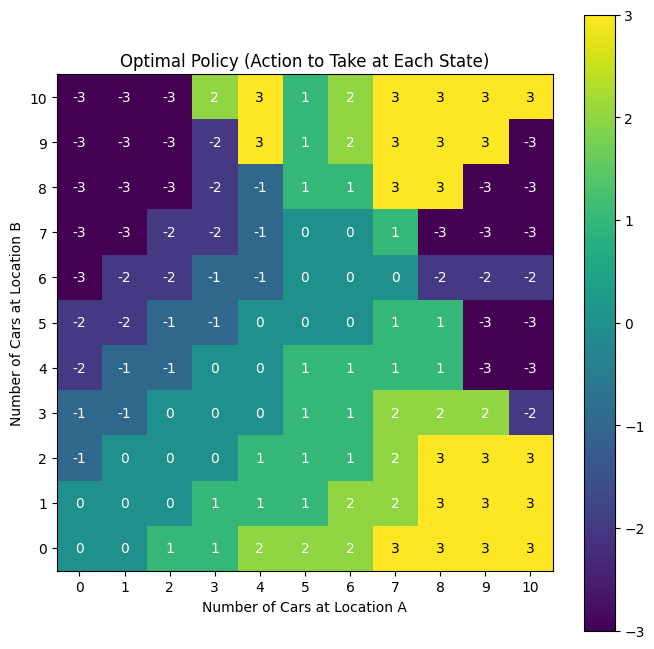

In [15]:
# Parameters for policy iteration
gamma = 0.9
theta = 1e-6

# Find the optimal policy using Q-value iteration
optimal_policy, optimal_value_function_q = find_optimal_policy_q(t_r_dict)

print("Optimal Policy:", optimal_policy)
print("Value Function:", optimal_value_function_q)

# Extract V from Q
states = list(set([s for s, _ in t_r_dict.keys()]))
V = {state: 0 for state in states}
optimal_V = policy_evaluation_v(states, optimal_policy, V, t_r_dict, gamma, theta)
print("Optimal Value Function:", optimal_V)

# Draw the GridWorld with the optimal policy and value function
plot_car_rental_policy(optimal_policy, max_cars=env.max_cars)

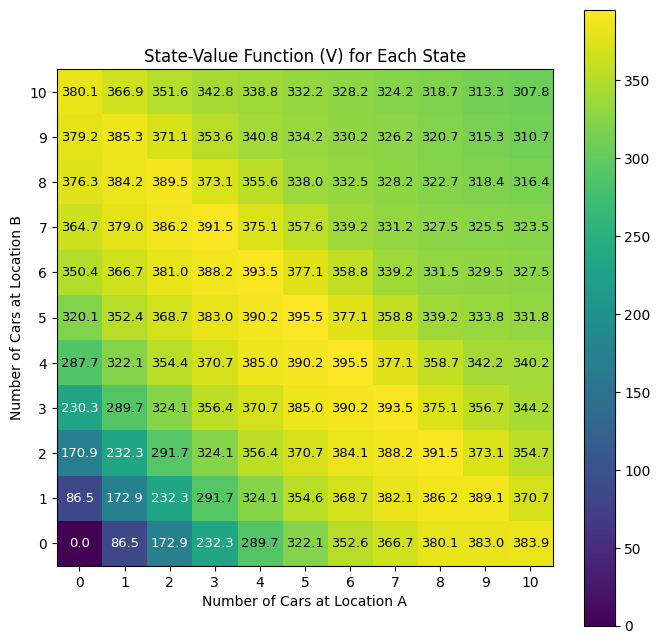

In [16]:
plot_car_rental_value_function(optimal_V, max_cars=env.max_cars)